In [64]:
import pickle
import networkx as nx
from cdlib import evaluation
from cdlib.classes import NodeClustering
import pickle
from cdlib import algorithms
from cdlib import viz
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random
import scipy.spatial as spatial
import numpy as np

In [65]:
GRAPH_FILENAME = "./jpetstore/jpetstore_128scenarios_nopolicies_sobol_graph.pkl"
java_graph = None
with open(GRAPH_FILENAME, 'rb') as f:
     java_graph = pickle.load(f)

java_graph.nodes(data=True)
java_graph.edges(data=True)

EdgeDataView([('AccountActionBean.java', 'AbstractActionBean.java', {'weight': 105}), ('AccountActionBean.java', 'Account.java', {'weight': 105}), ('AccountActionBean.java', 'AccountActionBean.java', {'weight': 20}), ('AccountActionBean.java', 'AccountService.java', {'weight': 25}), ('AccountActionBean.java', 'CatalogService.java', {'weight': 15}), ('AccountActionBean.java', 'AccountActionBeanTest.java', {'weight': 175}), ('AccountActionBean.java', 'OrderActionBean.java', {'weight': 20}), ('AbstractActionBean.java', 'AccountActionBeanTest.java', {'weight': 5}), ('AbstractActionBean.java', 'CartActionBean.java', {'weight': 105}), ('AbstractActionBean.java', 'CatalogActionBean.java', {'weight': 105}), ('AbstractActionBean.java', 'CatalogActionBeanTest.java', {'weight': 5}), ('AbstractActionBean.java', 'OrderActionBean.java', {'weight': 125}), ('AbstractActionBean.java', 'OrderActionBeanTest.java', {'weight': 5}), ('Account.java', 'AccountActionBeanTest.java', {'weight': 80}), ('Account.j

In [79]:
PARTITIONS_FILENAME = "./jpetstore/jpetstore_128scenarios_nopolicies_sobol_partitions.pkl"
partitions_dict = None
with open(PARTITIONS_FILENAME, 'rb') as f:
     partitions_dict = pickle.load(f)

print("partitions:", len(partitions_dict))

key_0 = list(partitions_dict.keys())[10]
partitions_dict[key_0]

partitions: 1208


{0: ['Order.java',
  'LineItem.java',
  'Account.java',
  'AccountActionBean.java',
  'CategoryMapper.java',
  'CartActionBean.java',
  'OrderActionBean.java',
  'AbstractActionBean.java',
  'CatalogService.java',
  'ProductMapper.java',
  'Cart.java',
  'CatalogActionBean.java',
  'CartItem.java',
  'AccountService.java',
  'AccountMapper.java',
  'Item.java',
  'Product.java',
  'ItemMapper.java',
  'Sequence.java',
  'OrderService.java',
  'LineItemMapper.java',
  'OrderMapper.java',
  'SequenceMapper.java'],
 1: ['CategoryMapper.java',
  'CartActionBean.java',
  'OrderActionBean.java',
  'AbstractActionBean.java',
  'CatalogService.java',
  'ProductMapper.java',
  'Cart.java',
  'CatalogActionBean.java',
  'CartItem.java',
  'Order.java',
  'LineItem.java',
  'Account.java',
  'AccountActionBean.java',
  'AccountService.java',
  'AccountMapper.java',
  'Item.java',
  'Product.java',
  'ItemMapper.java',
  'Sequence.java',
  'OrderService.java',
  'LineItemMapper.java',
  'OrderMapp

In [67]:
key_0 = list(partitions_dict.keys())[11]
n_partitions = list(partitions_dict[key_0].values())
print(len(n_partitions), "clusters")
n_clustering = NodeClustering(communities=n_partitions, graph=java_graph, overlap=True)

8 clusters


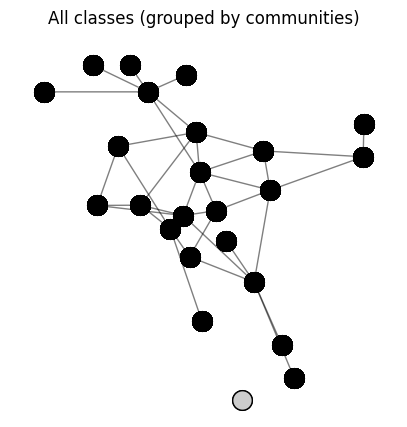

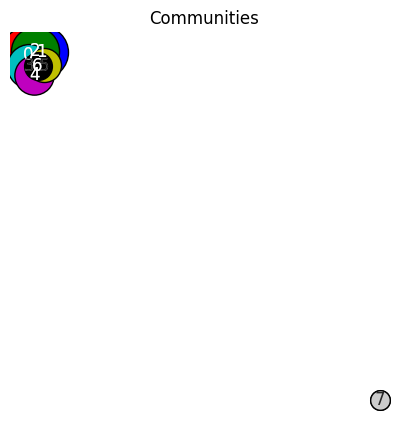

In [68]:
g = java_graph #nx.karate_club_graph()
lp_coms = n_clustering #algorithms.label_propagation(g)

pos = nx.spring_layout(g)
#pos = nx.random_layout(g)
viz.plot_network_clusters(g, lp_coms, pos, figsize=(5, 5), plot_overlaps=False, plot_labels=False) #, top_k=3)
plt.title("All classes (grouped by communities)")
plt.show()
viz.plot_community_graph(g, lp_coms, figsize=(5, 5), plot_overlaps=True, plot_labels=True)
plt.title("Communities")
plt.show()

In [173]:
# Omega index indicates the similarity between two partitions
# If omega = 1, the two partitions are identical (distance = 0), and omega = 0 (distance = 1) is the opposite case
# Thus, omega works as a similarity index
def compute_omega_index(partition_i, partition_j, graph, distance=False):
    clustering_i = NodeClustering(communities=list(partition_i.values()), graph=graph, overlap=True)
    clustering_j = NodeClustering(communities=list(partition_j.values()), graph=graph, overlap=True)
    if distance:
        return 1 - evaluation.omega(clustering_i, clustering_j).score
    else:
        return evaluation.omega(clustering_i, clustering_j).score
    
def compute_indices(partitions_dict, graph, distance=False, metric="omega"):
    omega_scores = dict() # This computation can take some time
    for i in tqdm(partitions_dict.keys()):
        omega_scores[i] = dict()
        partition_i = list(partitions_dict[i].values())
        clustering_i = NodeClustering(communities=partition_i, graph=graph, overlap=True)
        for j in partitions_dict.keys():
            partition_j = list(partitions_dict[j].values())
            clustering_j = NodeClustering(communities=partition_j, graph=graph, overlap=True)
            if metric == "omega":
                omega_scores[i][j] = evaluation.omega(clustering_i, clustering_j).score
            elif metric == "mutualinfo_lfk":
                omega_scores[i][j] = evaluation.overlapping_normalized_mutual_information_LFK(clustering_i, clustering_j).score
            elif metric == "mutualinfo_mgh":
                omega_scores[i][j] = evaluation.overlapping_normalized_mutual_information_MGH(clustering_i, clustering_j).score
            else:
                raise ValueError("Invalid metric")
            if distance:
                omega_scores[i][j] = 1 - omega_scores[i][j] 

    omega_scores_df = pd.DataFrame(omega_scores)
    return omega_scores_df

In [182]:
SIMILARITY_FILENAME = "./jpetstore/jpetstore_omega_scores.csv"
# SIMILARITY_FILENAME = "./jpetstore/jpetstore_milfk_scores.csv"
# SIMILARITY_FILENAME = "./jpetstore/jpetstore_mimgh_scores.csv"
# partitions_similarity_df = compute_indices(partitions_dict, java_graph, metric="mutualinfo_lfk")
# print(partitions_similarity_df.shape)
# partitions_similarity_df.to_csv(SIMILARITY_FILENAME)

In [183]:
partitions_distance_df = 1 - pd.read_csv(SIMILARITY_FILENAME, index_col=0)
print(partitions_distance_df.shape)
partitions_distance_df

(1208, 1208)


,resolution_69_alpha_40_mfuzzy_6_mthreshold_10,resolution_69_alpha_17_mfuzzy_6_mthreshold_10,resolution_69_alpha_40_mfuzzy_5_mthreshold_10,resolution_69_alpha_40_mfuzzy_6_mthreshold_6,resolution_51_alpha_40_mfuzzy_6_mthreshold_10,resolution_51_alpha_40_mfuzzy_5_mthreshold_6,resolution_51_alpha_17_mfuzzy_6_mthreshold_6,resolution_51_alpha_17_mfuzzy_5_mthreshold_10,resolution_69_alpha_17_mfuzzy_5_mthreshold_6,resolution_51_alpha_17_mfuzzy_5_mthreshold_6,...,resolution_11_alpha_41_mfuzzy_5_mthreshold_4,resolution_11_alpha_37_mfuzzy_5_mthreshold_4,resolution_11_alpha_41_mfuzzy_2_mthreshold_4,resolution_11_alpha_41_mfuzzy_5_mthreshold_5,resolution_60_alpha_41_mfuzzy_5_mthreshold_4,resolution_60_alpha_41_mfuzzy_2_mthreshold_5,resolution_60_alpha_37_mfuzzy_5_mthreshold_5,resolution_60_alpha_37_mfuzzy_2_mthreshold_4,resolution_11_alpha_37_mfuzzy_2_mthreshold_5,resolution_60_alpha_37_mfuzzy_2_mthreshold_5
resolution_69_alpha_40_mfuzzy_6_mthreshold_10,0.000000,0.875536,0.000000,0.000000,0.000000,0.000000,0.000000,0.909091,0.000000,0.923077,...,0.923077,0.000000,0.904360,0.923077,0.000000,0.875536,0.000000,0.923077,0.914213,0.900104
resolution_69_alpha_17_mfuzzy_6_mthreshold_10,0.875536,0.000000,0.875536,0.875536,0.875536,0.875536,0.875536,0.797772,0.875536,0.923077,...,0.923077,0.875536,0.901446,0.923077,0.875536,0.919779,0.875536,0.973620,0.953183,0.930319
resolution_69_alpha_40_mfuzzy_5_mthreshold_10,0.000000,0.875536,0.000000,0.000000,0.000000,0.000000,0.000000,0.909091,0.000000,0.923077,...,0.923077,0.000000,0.904360,0.923077,0.000000,0.875536,0.000000,0.923077,0.914213,0.900104
resolution_69_alpha_40_mfuzzy_6_mthreshold_6,0.000000,0.875536,0.000000,0.000000,0.000000,0.000000,0.000000,0.909091,0.000000,0.923077,...,0.923077,0.000000,0.904360,0.923077,0.000000,0.875536,0.000000,0.923077,0.914213,0.900104
resolution_51_alpha_40_mfuzzy_6_mthreshold_10,0.000000,0.875536,0.000000,0.000000,0.000000,0.000000,0.000000,0.909091,0.000000,0.923077,...,0.923077,0.000000,0.904360,0.923077,0.000000,0.875536,0.000000,0.923077,0.914213,0.900104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
resolution_60_alpha_41_mfuzzy_2_mthreshold_5,0.875536,0.919779,0.875536,0.875536,0.875536,0.875536,0.875536,0.964793,0.875536,0.923077,...,0.923077,0.875536,0.769264,0.923077,0.875536,0.000000,0.875536,0.889114,0.462975,0.750701
resolution_60_alpha_37_mfuzzy_5_mthreshold_5,0.000000,0.875536,0.000000,0.000000,0.000000,0.000000,0.000000,0.909091,0.000000,0.923077,...,0.923077,0.000000,0.904360,0.923077,0.000000,0.875536,0.000000,0.923077,0.914213,0.900104
resolution_60_alpha_37_mfuzzy_2_mthreshold_4,0.923077,0.973620,0.923077,0.923077,0.923077,0.923077,0.923077,0.947540,0.923077,0.923077,...,0.923077,0.923077,0.586236,0.923077,0.923077,0.889114,0.923077,0.000000,0.896547,0.414301
resolution_11_alpha_37_mfuzzy_2_mthreshold_5,0.914213,0.953183,0.914213,0.914213,0.914213,0.914213,0.914213,1.001894,0.914213,0.923077,...,0.923077,0.914213,0.948634,0.923077,0.914213,0.462975,0.914213,0.896547,0.000000,0.916944


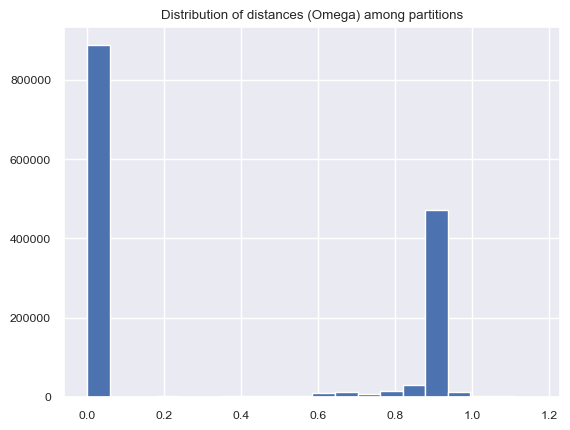

In [184]:
plt.hist(np.tril(partitions_distance_df).flatten(), bins=20)
plt.title("Distribution of distances (Omega) among partitions")
plt.show()

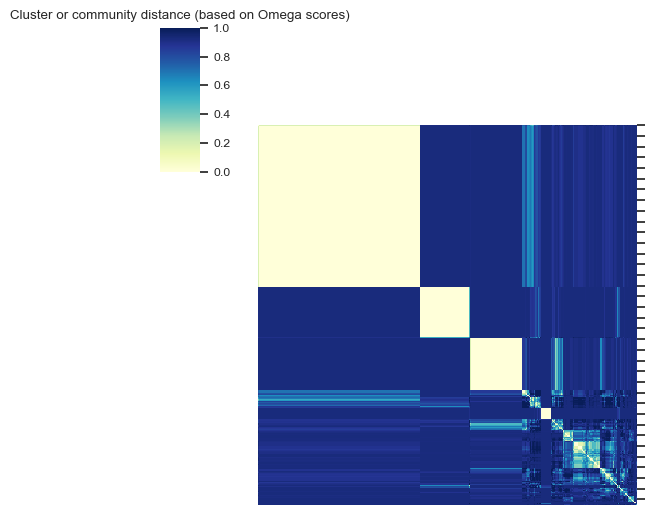

In [185]:
sns.set(font_scale=0.8)
ax = sns.clustermap(partitions_distance_df, cmap='YlGnBu', robust=True, method="average", 
                    figsize=(8,8), vmax=1, vmin=0)
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)
ax.ax_heatmap.set_xticklabels([])
ax.ax_heatmap.set_yticklabels([])

#ax.set_xlabel('configurations')
#ax.set_ylabel('tradeoffs')
#ax.set_xticks([])
#ax.set_yticks([])
plt.title("Cluster or community distance (based on Omega scores)")
plt.show()

In [178]:
def plot_2d_embeddings(embeddings_2d=None, title="", distance_df=None, view="matplotlib", partitions_dict=None):

    if embeddings_2d is None:
        mds = MDS(dissimilarity='precomputed', random_state=0)
        embeddings_2d = mds.fit_transform(distance_df)

    if view == "matplotlib":
        #create scatterplot
        plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], alpha=0.6)
        #add axis labels
        plt.xlabel('x')
        plt.ylabel('y')
    
    else: # sns
        df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
        df['cluster size'] = [len(partitions_dict[k]) for k in partitions_dict.keys()]
        sns.scatterplot(data=df, x="x", y="y", hue="cluster size", palette="tab10", size="cluster size", 
                alpha=0.65, legend='full', sizes=(20, 200))

    #add lables to each point
    #for i, txt in enumerate(omega_scores_df.index):
    #for i in range(omega_scores_df.shape[0]):
    #    plt.annotate(i, (embeddings_2d[:,0][i], embeddings_2d[:,1][i]))

    #display scatterplot
    plt.title(title)
    plt.grid(False)
    plt.show()

In [186]:
# https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/

mds = MDS(dissimilarity='precomputed', random_state=0)
embeddings_2d_partitions = mds.fit_transform(partitions_distance_df)

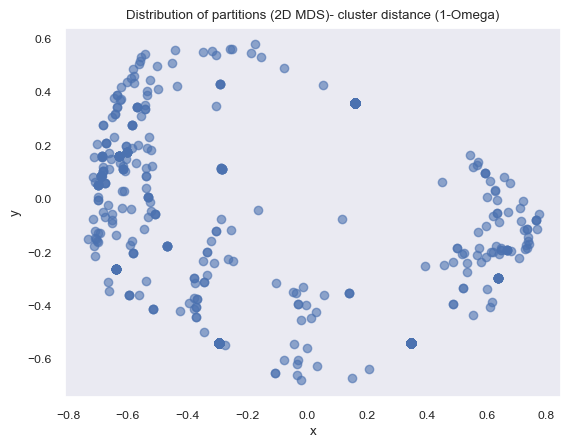

In [187]:
plot_2d_embeddings(embeddings_2d_partitions, title="Distribution of partitions (2D MDS)- cluster distance (1-Omega)")

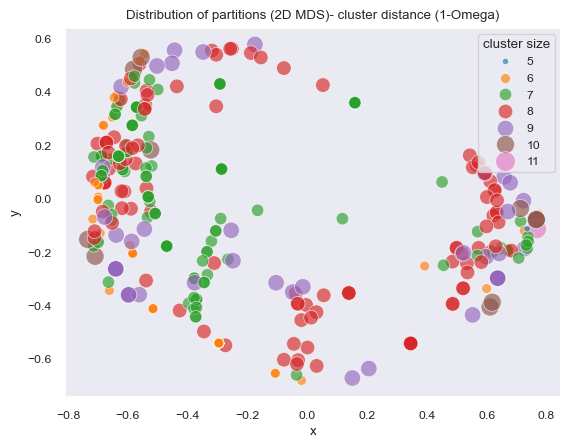

In [188]:
plot_2d_embeddings(embeddings_2d_partitions, title="Distribution of partitions (2D MDS)- cluster distance (1-Omega)",
                   view="sns", partitions_dict=partitions_dict)

Number of partitions: 1208
Reference partition: 1156 resolution_84_alpha_55_mfuzzy_9_mthreshold_10


100%|██████████| 1208/1208 [00:02<00:00, 492.56it/s]


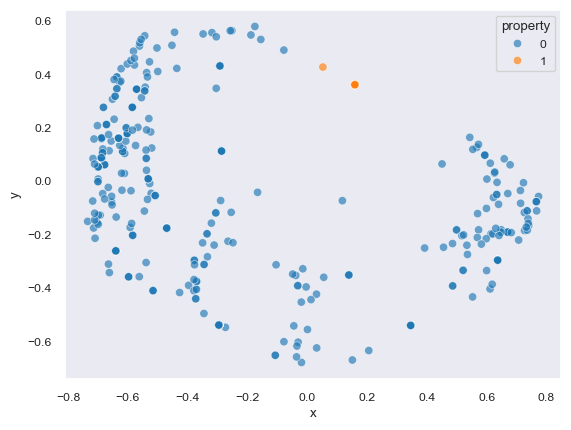

In [189]:
n = len(partitions_dict.keys())
print("Number of partitions:", n)
#random.seed(30)
p = random.randrange(0,n)
reference_key = list(partitions_dict.keys())[p]
reference_partition = partitions_dict[reference_key]
print("Reference partition:", p, reference_key)
#reference_partition

similarity_scores = [] # Compute the similarity of each partition with respect to the reference partition
for i in tqdm(partitions_dict.keys()):
    score = compute_omega_index(partitions_dict[i], reference_partition, java_graph)
    similarity_scores.append(score)

df = pd.DataFrame(embeddings_2d_partitions, columns=['x', 'y'])
threshold = 0.8
df['property'] = [1 if x >= threshold else 0 for x in similarity_scores]
sns.scatterplot(data=df, x="x", y="y", hue="property", palette="tab10", 
                alpha=0.65, legend='full', sizes=(20, 200))
plt.grid(False)
#plt.title("Spatial distribution (2D MDS) of the clusters (partitions)")
plt.show()

In [202]:
def get_parameter_value(partition_key, parameter):
    values = partition_key.split("_")
    if parameter in values:
        index = values.index(parameter)
        return int(values[index + 1])
    return None

def compute_parameter_distances(partitions_dict, parameter='resolution', filename=None, min_max=None):
    distances = dict() 
    for i in tqdm(partitions_dict.keys()):
        distances[i] = dict()
        value_i = get_parameter_value(i, parameter)
        for j in partitions_dict.keys():
            value_j = get_parameter_value(j, parameter)
            if min_max is None:
                distances[i][j] = abs(value_i - value_j)
            else:
                x_i = (value_i - min_max[0]) / (min_max[1] - min_max[0])
                x_j = (value_j - min_max[0]) / (min_max[1] - min_max[0])
                distances[i][j] = abs(x_i - x_j)
    distances_df = pd.DataFrame(distances)
    if filename is not None:
        distances_df.to_csv(filename)
    return distances_df

def check_experiments(distance_df, p_step, partitions_dict, sim_threshold=0.95, binary=True):
    count_experiments = []
    for exp in distance_df.columns:
        # Get experiments being close enough to target exp
        indices = distance_df.loc[distance_df[exp] <= p_step].index
        ref = partitions_dict[exp]
        # Discard experiments being dissimlar to target exp
        selected_indices = []
        all_valid_indices = True
        for idx in indices:
            if compute_omega_index(ref, partitions_dict[idx], java_graph) >= sim_threshold:
                selected_indices.append(idx)
            else:
                all_valid_indices = False
                break
        if all_valid_indices:
            if binary:      
                count_experiments.append(1)
            else:
                count_experiments.append(len(selected_indices))
        else:
            #print("\t", exp, "indices so far (but discarded):", len(selected_indices))
            count_experiments.append(0)
    return count_experiments

Computing parameter distances (resolution)...


100%|██████████| 1208/1208 [00:02<00:00, 560.03it/s]


(1208, 1208)
min-max distances: 0.010101010101010055 1.0


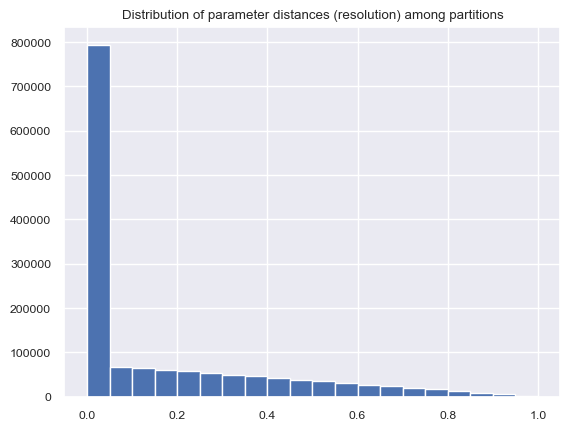

In [191]:
print("Computing parameter distances (resolution)...")
resolution_distance_df = compute_parameter_distances(partitions_dict, min_max=(1, 100))
print(resolution_distance_df.shape)
resolution_distance_np = np.tril(resolution_distance_df).flatten()
min_non_zero = np.min(resolution_distance_np[np.nonzero(resolution_distance_np)])
print("min-max distances:", min_non_zero, resolution_distance_np.max())

plt.hist(resolution_distance_np, bins=20)
plt.title("Distribution of parameter distances (resolution) among partitions")
plt.show()

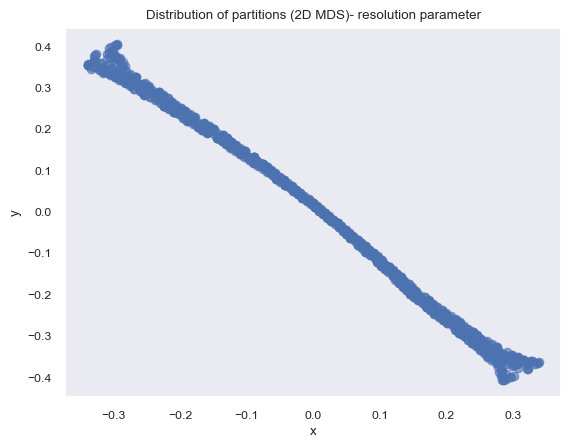

In [192]:
plot_2d_embeddings(title="Distribution of partitions (2D MDS)- resolution parameter", distance_df=resolution_distance_df)

In [199]:
# Generate code for a binary search of a suitable parameter value within a continuous interval. 
# The stopping criterion for the search is  given by an error threshold. 
# The suitability of the parameter value is given by another function.
def binary_search(distance_df, partitions_dict, threshold=0.95, max_trials=25, freq=5, interval=(0.0,1.0), tolerance=0.0005):
    print("threshold=", threshold, " max_trials=", max_trials, " interval=", interval)
    left = interval[0]
    right = interval[1]
    n = 1
    best_f = None
    best_mid = None
    mid = None
    for n in tqdm(range(1, max_trials+1)):
        if (abs(right-left) >= tolerance):
            mid = (left + right) / 2
            if n % freq == 0:
                print(n, "r=", mid, "...")
            f = check_experiments(distance_df, mid, partitions_dict, sim_threshold=threshold)
            f_sum = sum(f)
            if f_sum == 0: # Mid point is not suitable yet
                right = mid
            else:
                print(n,"r=", mid, ", satisfying distance found!", "count=", f_sum, "coverage=", f_sum/len(partitions_dict))
                best_f = f
                best_mid = mid
                left = mid
        else:
            print("Stopping criterion reached:", tolerance, " r=", mid)
            break

    if best_f is None:
        print("No suitable distance found")
        return mid, best_f, []
    else:
        selected_exps = [col for idx, col in zip(best_f, distance_df.columns) if idx == 1]
        return best_mid, sum(best_f)/len(partitions_dict), selected_exps

In [203]:
# Test the binary search
radius, coverage, configs = binary_search(resolution_distance_df, partitions_dict, threshold=0.95, 
                                          max_trials=50, tolerance=0.0001)
print()
print("Max radius:", radius)
radius = radius * (100-1) + 1
print("Max resolution delta (r denormalized):", radius)
print("Coverage of configurations (%):", round(r*100,2))
print(len(configs), configs)

threshold= 0.95  max_trials= 50  interval= (0.0, 1.0)


  8%|▊         | 4/50 [00:42<08:06, 10.57s/it]

5 r= 0.03125 ...


 14%|█▍        | 7/50 [00:58<04:58,  6.94s/it]

7 r= 0.0078125 , satisfying distance found! count= 38 coverage= 0.03145695364238411


 18%|█▊        | 9/50 [01:09<04:08,  6.05s/it]

9 r= 0.009765625 , satisfying distance found! count= 38 coverage= 0.03145695364238411
10 r= 0.0107421875 ...


 20%|██        | 10/50 [01:14<03:58,  5.97s/it]